In [1]:
import torch
from vn1forecasting.data import DataPreprocessor, generate_time_series_samples, prepare_batch_data
from vn1forecasting.model import MultiTimeSeriesTransformer
from vn1forecasting.pipeline import train_model, validate_model_with_loss, run_inference_on_test
from vn1forecasting.results import save_predictions_in_custom_format, evaluate_forecasts
from vn1forecasting.utils import plot_predictions_vs_actual_with_price

# Set the device to MPS (Metal Performance Shaders) if available; otherwise, fallback to CPU
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [2]:
preprocessor = DataPreprocessor()
preprocessed_df = preprocessor.preprocess_data()

In [3]:
preprocessed_df.tail(20)

,Client,Warehouse,Product,Date,Sales,use,Price,rolling_4w_sales,rolling_13w_sales
1966688,45,309,11147,2023-11-20,0.442654,train,0.859991,0.358824,0.378652
1966689,45,309,11147,2023-11-27,0.442654,train,0.900000,0.335294,0.396629
1966690,45,309,11147,2023-12-04,0.100000,train,NaN,0.358824,0.405618
1966691,45,309,11147,2023-12-11,0.316191,train,0.900000,0.288235,0.369663
1966692,45,309,11147,2023-12-18,0.316191,train,0.900000,0.217647,0.351685
1966693,45,309,11147,2023-12-25,0.316191,train,0.767206,0.194118,0.315730
1966694,45,309,11147,2024-01-01,0.532381,train,0.873328,0.170588,0.324719
1966695,45,309,11147,2024-01-08,0.316191,test,NaN,0.241176,0.351685
1966696,45,309,11147,2024-01-15,0.316191,test,NaN,0.241176,0.342697
1966697,45,309,11147,2024-01-22,0.442654,test,NaN,0.241176,0.297753


<Axes: xlabel='Date'>

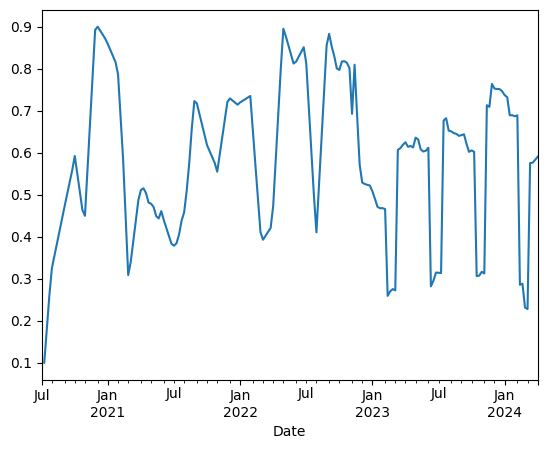

In [4]:
preprocessed_df.loc[
    (preprocessed_df.Client==0)&
    (preprocessed_df.Warehouse==3)&
    (preprocessed_df.Product==897)
].set_index('Date').rolling_13w_sales.plot()

<Axes: >

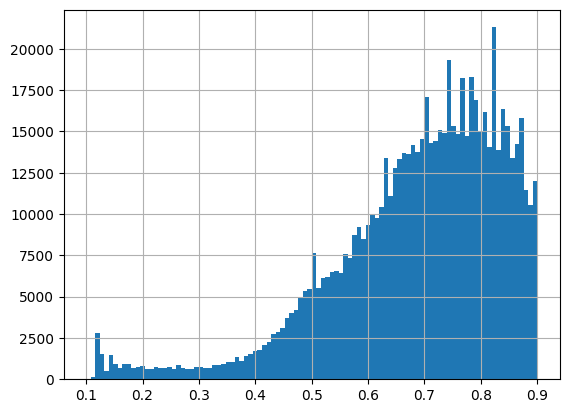

In [5]:
preprocessed_df.Price.hist(bins=100, range=(0.1, 0.8999))

<Axes: >

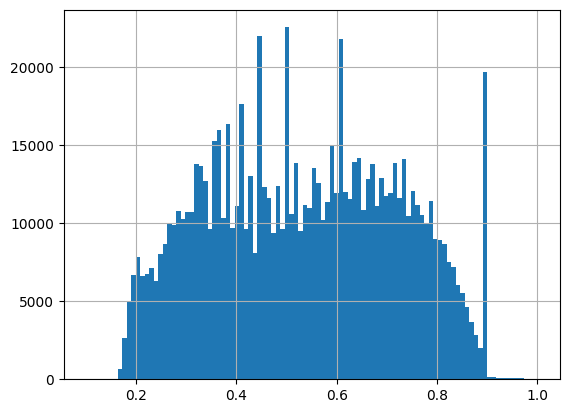

In [6]:
preprocessed_df.Sales.hist(bins=100, range=(0.1001,1))

In [7]:
# Generate train and validation samples
n_samples = 20  # Number of samples to generate
train_samples, valid_samples = generate_time_series_samples(preprocessed_df, n_samples)
train_samples[0]['cursor_date'], train_samples[0]['sales'], train_samples[0]['price'], train_samples[0]['target']

(Timestamp('2022-04-04 00:00:00'),
 array([0.36543801, 0.27695867, 0.1       , 0.24023643, 0.1       ,
        0.1       , 0.1       , 0.1       , 0.3483929 , 0.36543801,
        0.36543801, 0.36543801, 0.36543801, 0.36543801, 0.36543801,
        0.36543801, 0.36543801, 0.36543801, 0.36543801, 0.36543801,
        0.36543801, 0.36543801, 0.36543801, 0.36543801, 0.36543801,
        0.32871577, 0.36543801, 0.36543801, 0.36543801, 0.36543801,
        0.36543801, 0.36543801, 0.36543801, 0.36543801, 0.24023643,
        0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
        0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
        0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
        0.1       , 0.1       ]),
 array([0.12517754, 0.12517754,        nan,        nan,        nan,
               nan,        nan,        nan, 0.12517754,        nan,
        0.12517754, 0.12517754, 0.12473485, 0.12440284, 0.12440284,
        0.12440284, 0.13145808, 0.17378954, 0.1

In [8]:
batch_data = prepare_batch_data(train_samples, mode='train')
sales, price, decoder_input, wom, woy, moy, qoy, sales_padding_mask, price_padding_mask, price_validity_mask, target, client, warehouse, product, rolling_4w_sales, rolling_13w_sales = batch_data
price_padding_mask[0]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [9]:
# Model Initialization
model = MultiTimeSeriesTransformer(
    input_dim=1,
    d_model=64,
    nhead=4,
    num_encoder_layers=2,
    num_decoder_layers=2,
    dim_feedforward=256,
    num_wom=5,
    num_woy=53,
    num_moy=12,
    num_qoy=4,
    date_embedding_dim=3,
    num_clients=len(preprocessor.client_encoder.classes_),
    num_warehouses=len(preprocessor.warehouse_encoder.classes_),
    num_products=len(preprocessor.product_encoder.classes_),
    category_embedding_dim=16,
    dropout=0.1
)
model = model.to(device)

/Users/senoni/noni/vn1forecasting/.venv/lib/python3.11/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [10]:
trained_model, valid_samples, val_predictions, val_targets = train_model(
    model=model,
    preprocessed_df=preprocessed_df,
    device=device,
    generate_time_series_samples=generate_time_series_samples,
    prepare_batch_data=prepare_batch_data,
    validate_model_with_loss=validate_model_with_loss,
    phases_config=[
        ('init', 1, 24, 50000, 1e-3),
        ('core', 51, 512, 200000, 1e-3),
        ('core', 51, 512, 1, 1e-4),
        ('core', 51, 512, 1, 1e-5),
        ('tune', 51, 512, 200000, 1e-5),
        ('finish', 51, 512, 200000, 1e-5)
    ],

)

Training samples: 29898
Epoch 0, Train Loss: 0.6171, Validation Loss: 0.3686
Validation MSE: 0.0265
Validation MAE: 0.0937
Current learning rate: 1.00e-03
Training samples: 188410
Epoch 0, Train Loss: 0.3797, Validation Loss: 0.4403
Validation MSE: 0.0308
Validation MAE: 0.1026
Current learning rate: 1.00e-03
Epoch 1, Train Loss: 0.3669, Validation Loss: 0.3283
Validation MSE: 0.0291
Validation MAE: 0.0917
Current learning rate: 1.00e-03
Epoch 2, Train Loss: 0.3464, Validation Loss: 0.3158
Validation MSE: 0.0270
Validation MAE: 0.0877
Current learning rate: 1.00e-03
Epoch 3, Train Loss: 0.3400, Validation Loss: 0.3885
Validation MSE: 0.0274
Validation MAE: 0.0954
Current learning rate: 1.00e-03
Epoch 4, Train Loss: 0.3278, Validation Loss: 0.3119
Validation MSE: 0.0262
Validation MAE: 0.0860
Current learning rate: 1.00e-03
Epoch 5, Train Loss: 0.3186, Validation Loss: 0.3313
Validation MSE: 0.0256
Validation MAE: 0.0860
Current learning rate: 1.00e-03
Epoch 6, Train Loss: 0.3071, Valid

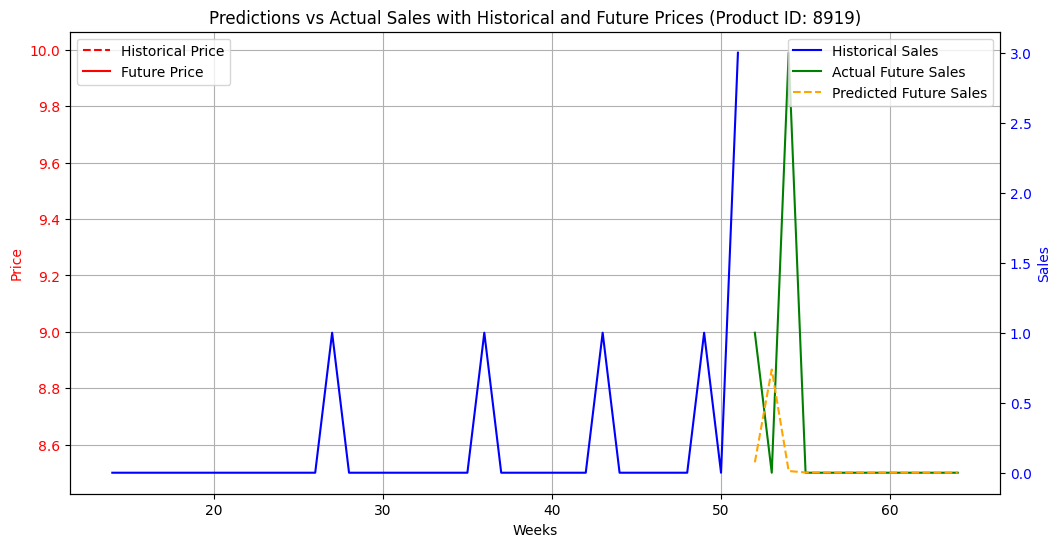

In [11]:
# Select a sample from validation data
sample_index = 7
sample = valid_samples[sample_index]

# Plot predictions vs actuals
plot_predictions_vs_actual_with_price(
    sample=sample,
    scalers=preprocessor.normalization_params,
    preprocessor=preprocessor,
    val_predictions=val_predictions[sample_index],
    val_targets=val_targets[sample_index]
)


In [12]:
# Generate test samples
test_samples = generate_time_series_samples(
    preprocessed_df,
    mode='test'
)


In [13]:
# Run inference
test_predictions = run_inference_on_test(
    model=model,
    test_samples=test_samples,
    batch_size=512,
    prepare_batch_data=prepare_batch_data,
    preprocessor=preprocessor,
    device=device
)

In [14]:
output_path = "./test_predictions_custom.csv"

# Save predictions in custom format
formatted_df = save_predictions_in_custom_format(
    test_predictions=test_predictions, 
    test_samples=test_samples, 
    output_path=output_path
)

# Preview the formatted DataFrame
print(formatted_df.head())


Predictions saved in custom format to ./test_predictions_custom.csv
  unique_id         ds    senoni
0   0-1-367 2024-01-08  0.769884
1   0-1-367 2024-01-15  0.993015
2   0-1-367 2024-01-22  0.765335
3   0-1-367 2024-01-29  1.249252
4   0-1-367 2024-02-05  1.208102


In [15]:
forecast_paths = [
    ("../data/solution_1st_place.csv", "1st"),
    ("../data/solution_2nd_place.csv", "2nd"),
    ("../data/solution_3rd_place.csv", "3rd"),
    ("../data/solution_4th_place.csv", "4th"),
    ("../data/solution_5th_place.csv", "5th"),
]

# Evaluate forecasts
actual_path = "../data/phase_2_sales.csv"
score_df = evaluate_forecasts(actual_path, formatted_df, forecast_paths)
print("Model Scores:")
print(score_df)


Model Scores:
    model   score
0     1st  0.4637
1     2nd  0.4657
2     3rd  0.4758
3     4th  0.4774
4     5th  0.4808
5  senoni  0.5047
